In [7]:
import pandas as pd 
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Dataset

In [8]:
data = pd.read_csv("./data/ATP.csv")
data

,best_of,draw_size,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,l_df,...,winner_age,winner_entry,winner_hand,winner_ht,winner_id,winner_ioc,winner_name,winner_rank,winner_rank_points,winner_seed
0,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,R,NaN,110023,AUS,Richard Coulthard,NaN,NaN,NaN
1,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.520876,NaN,R,NaN,109803,AUS,John Brown,NaN,NaN,NaN
2,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.216290,NaN,R,NaN,100257,AUS,Ross Case,NaN,NaN,NaN
3,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22.264203,NaN,R,NaN,100105,AUS,Allan Stone,NaN,NaN,5.0
4,5,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.861739,NaN,R,NaN,109966,AUS,Warren Jacques,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169685,3,NaN,54.0,43.0,16.0,15.0,13.0,5.0,3.0,1.0,...,22.740000,NaN,R,NaN,106426,CHI,Christian Garin,92.0,620.0,NaN
169686,3,NaN,23.0,12.0,5.0,7.0,0.0,8.0,3.0,2.0,...,20.180000,NaN,R,NaN,134770,NOR,Casper Ruud,108.0,527.0,NaN
169687,3,NaN,56.0,39.0,13.0,12.0,5.0,5.0,3.0,1.0,...,28.780000,NaN,L,185.0,105550,ARG,Guido Pella,48.0,975.0,3.0
169688,3,NaN,34.0,24.0,11.0,10.0,5.0,6.0,3.0,0.0,...,22.740000,NaN,R,NaN,106426,CHI,Christian Garin,92.0,620.0,NaN


# Preprossesing

## Info

In [9]:
loser = data.iloc[:,2:21]
winner = data.iloc[:,30::]
loser = loser.drop(columns=["loser_name","loser_entry","loser_seed"])
winner = winner.drop(columns=["winner_name","winner_entry","winner_seed"])
loser.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169690 entries, 0 to 169689
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   l_1stIn            83415 non-null   float64
 1   l_1stWon           83415 non-null   float64
 2   l_2ndWon           83415 non-null   float64
 3   l_SvGms            83415 non-null   float64
 4   l_ace              83415 non-null   float64
 5   l_bpFaced          83415 non-null   float64
 6   l_bpSaved          83415 non-null   float64
 7   l_df               83415 non-null   float64
 8   l_svpt             83415 non-null   float64
 9   loser_age          164700 non-null  float64
 10  loser_hand         169605 non-null  object 
 11  loser_ht           139052 non-null  float64
 12  loser_id           169690 non-null  int64  
 13  loser_ioc          169690 non-null  object 
 14  loser_rank         145909 non-null  float64
 15  loser_rank_points  93025 non-null   float64
dtypes:

In [10]:
winner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169690 entries, 0 to 169689
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   w_1stIn             83415 non-null   float64
 1   w_1stWon            83415 non-null   float64
 2   w_2ndWon            83415 non-null   float64
 3   w_SvGms             83415 non-null   float64
 4   w_ace               83415 non-null   float64
 5   w_bpFaced           83415 non-null   float64
 6   w_bpSaved           83415 non-null   float64
 7   w_df                83415 non-null   float64
 8   w_svpt              83415 non-null   float64
 9   winner_age          167929 non-null  float64
 10  winner_hand         169651 non-null  object 
 11  winner_ht           150884 non-null  float64
 12  winner_id           169690 non-null  int64  
 13  winner_ioc          169690 non-null  object 
 14  winner_rank         149773 non-null  float64
 15  winner_rank_points  94291 non-null

## Dropna

In [11]:
loser = loser.dropna()
loser["class"] = 0
loser.columns = ['1stIn', '1stWon', '2ndWon', 'SvGms', 'ace', 'bpFaced',
       'bpSaved', 'df', 'svpt', 'age', 'hand', 'ht',
       'id', 'ioc', 'rank', 'rank_points', 'class']
loser

,1stIn,1stWon,2ndWon,SvGms,ace,bpFaced,bpSaved,df,svpt,age,hand,ht,id,ioc,rank,rank_points,class
76863,30.0,17.0,7.0,8.0,3.0,6.0,2.0,0.0,46.0,20.64,R,175.0,101746,ITA,78.0,459.0,0
76864,30.0,22.0,6.0,8.0,4.0,11.0,7.0,7.0,56.0,31.82,R,188.0,100587,NZL,220.0,114.0,0
76865,43.0,24.0,14.0,11.0,1.0,8.0,4.0,3.0,68.0,21.70,R,185.0,101601,NZL,212.0,116.0,0
76866,61.0,38.0,15.0,13.0,3.0,12.0,8.0,2.0,96.0,23.85,L,173.0,101332,ISR,72.0,483.0,0
76867,25.0,21.0,12.0,9.0,1.0,6.0,4.0,3.0,49.0,20.70,R,196.0,101735,AUS,28.0,876.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169672,35.0,27.0,12.0,9.0,7.0,4.0,2.0,3.0,59.0,37.20,R,183.0,103893,ITA,106.0,544.0,0
169675,62.0,48.0,21.0,15.0,5.0,11.0,9.0,5.0,108.0,35.10,R,185.0,104291,TUN,45.0,1007.0,0
169676,68.0,48.0,16.0,12.0,3.0,8.0,7.0,2.0,100.0,31.11,L,188.0,105077,ESP,86.0,650.0,0
169682,23.0,18.0,12.0,9.0,3.0,5.0,2.0,1.0,48.0,29.91,R,185.0,105311,POR,38.0,1107.0,0


In [12]:
winner = winner.dropna()
winner["class"] = 1
winner.columns = ['1stIn', '1stWon', '2ndWon', 'SvGms', 'ace', 'bpFaced',
       'bpSaved', 'df', 'svpt', 'age', 'hand', 'ht',
       'id', 'ioc', 'rank', 'rank_points',"class"]
winner

,1stIn,1stWon,2ndWon,SvGms,ace,bpFaced,bpSaved,df,svpt,age,hand,ht,id,ioc,rank,rank_points,class
76863,37.0,30.0,7.0,9.0,1.0,6.0,5.0,0.0,53.0,25.61,R,180.0,101142,ESP,9.0,1487.0,1
76864,25.0,17.0,20.0,9.0,5.0,2.0,1.0,1.0,56.0,21.55,R,180.0,101613,USA,94.0,371.0,1
76865,55.0,35.0,16.0,12.0,2.0,4.0,2.0,4.0,80.0,25.32,R,185.0,101179,FRA,77.0,468.0,1
76866,55.0,35.0,14.0,13.0,0.0,10.0,6.0,1.0,82.0,25.83,R,180.0,101117,GER,65.0,502.0,1
76867,46.0,34.0,12.0,10.0,4.0,2.0,2.0,4.0,65.0,19.71,R,185.0,101901,USA,190.0,142.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169677,30.0,27.0,9.0,9.0,4.0,0.0,0.0,0.0,43.0,28.78,L,185.0,105550,ARG,48.0,975.0,1
169680,52.0,40.0,14.0,13.0,7.0,5.0,3.0,9.0,83.0,31.78,R,188.0,104919,ARG,55.0,895.0,1
169684,39.0,26.0,12.0,8.0,5.0,4.0,4.0,1.0,57.0,28.78,L,185.0,105550,ARG,48.0,975.0,1
169687,48.0,36.0,19.0,12.0,5.0,2.0,0.0,1.0,76.0,28.78,L,185.0,105550,ARG,48.0,975.0,1


## Concat

In [13]:
dataset = pd.concat([loser,winner],axis=0)
dataset

,1stIn,1stWon,2ndWon,SvGms,ace,bpFaced,bpSaved,df,svpt,age,hand,ht,id,ioc,rank,rank_points,class
76863,30.0,17.0,7.0,8.0,3.0,6.0,2.0,0.0,46.0,20.64,R,175.0,101746,ITA,78.0,459.0,0
76864,30.0,22.0,6.0,8.0,4.0,11.0,7.0,7.0,56.0,31.82,R,188.0,100587,NZL,220.0,114.0,0
76865,43.0,24.0,14.0,11.0,1.0,8.0,4.0,3.0,68.0,21.70,R,185.0,101601,NZL,212.0,116.0,0
76866,61.0,38.0,15.0,13.0,3.0,12.0,8.0,2.0,96.0,23.85,L,173.0,101332,ISR,72.0,483.0,0
76867,25.0,21.0,12.0,9.0,1.0,6.0,4.0,3.0,49.0,20.70,R,196.0,101735,AUS,28.0,876.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169677,30.0,27.0,9.0,9.0,4.0,0.0,0.0,0.0,43.0,28.78,L,185.0,105550,ARG,48.0,975.0,1
169680,52.0,40.0,14.0,13.0,7.0,5.0,3.0,9.0,83.0,31.78,R,188.0,104919,ARG,55.0,895.0,1
169684,39.0,26.0,12.0,8.0,5.0,4.0,4.0,1.0,57.0,28.78,L,185.0,105550,ARG,48.0,975.0,1
169687,48.0,36.0,19.0,12.0,5.0,2.0,0.0,1.0,76.0,28.78,L,185.0,105550,ARG,48.0,975.0,1


## Categorize

In [14]:
dataset["hand"] = dataset["hand"].astype('category')
dataset["hand"] = dataset["hand"].cat.codes
dataset["ioc"] = dataset["ioc"].astype('category')
dataset["ioc"] = dataset["ioc"].cat.codes
dataset

,1stIn,1stWon,2ndWon,SvGms,ace,bpFaced,bpSaved,df,svpt,age,hand,ht,id,ioc,rank,rank_points,class
76863,30.0,17.0,7.0,8.0,3.0,6.0,2.0,0.0,46.0,20.64,1,175.0,101746,39,78.0,459.0,0
76864,30.0,22.0,6.0,8.0,4.0,11.0,7.0,7.0,56.0,31.82,1,188.0,100587,55,220.0,114.0,0
76865,43.0,24.0,14.0,11.0,1.0,8.0,4.0,3.0,68.0,21.70,1,185.0,101601,55,212.0,116.0,0
76866,61.0,38.0,15.0,13.0,3.0,12.0,8.0,2.0,96.0,23.85,0,173.0,101332,38,72.0,483.0,0
76867,25.0,21.0,12.0,9.0,1.0,6.0,4.0,3.0,49.0,20.70,1,196.0,101735,3,28.0,876.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169677,30.0,27.0,9.0,9.0,4.0,0.0,0.0,0.0,43.0,28.78,0,185.0,105550,1,48.0,975.0,1
169680,52.0,40.0,14.0,13.0,7.0,5.0,3.0,9.0,83.0,31.78,1,188.0,104919,1,55.0,895.0,1
169684,39.0,26.0,12.0,8.0,5.0,4.0,4.0,1.0,57.0,28.78,0,185.0,105550,1,48.0,975.0,1
169687,48.0,36.0,19.0,12.0,5.0,2.0,0.0,1.0,76.0,28.78,0,185.0,105550,1,48.0,975.0,1


In [15]:
dataset = dataset.sample(frac=1)
X, y = dataset.iloc[:,:-1], dataset["class"]
dataset

,1stIn,1stWon,2ndWon,SvGms,ace,bpFaced,bpSaved,df,svpt,age,hand,ht,id,ioc,rank,rank_points,class
101094,50.0,40.0,23.0,15.0,19.0,9.0,6.0,7.0,90.0,20.47,1,196.0,102882,3,21.0,1368.0,1
107063,65.0,39.0,20.0,13.0,7.0,12.0,7.0,5.0,108.0,26.82,1,183.0,102035,70,25.0,1417.0,0
139788,52.0,35.0,14.0,10.0,2.0,9.0,7.0,3.0,75.0,28.88,0,173.0,103534,27,64.0,1144.0,1
155674,23.0,11.0,9.0,8.0,0.0,5.0,1.0,0.0,42.0,23.83,1,175.0,105575,45,157.0,347.0,0
119955,34.0,24.0,11.0,7.0,2.0,2.0,2.0,2.0,53.0,27.56,1,190.0,102562,19,9.0,2080.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100532,38.0,24.0,12.0,10.0,4.0,8.0,4.0,3.0,68.0,23.79,1,180.0,102227,2,90.0,528.0,0
149379,21.0,18.0,12.0,10.0,4.0,5.0,1.0,4.0,55.0,23.56,1,190.0,105208,44,79.0,660.0,0
102133,28.0,20.0,11.0,7.0,3.0,6.0,6.0,0.0,45.0,26.51,1,188.0,101843,24,7.0,2192.0,1
128424,143.0,122.0,32.0,34.0,51.0,5.0,4.0,8.0,198.0,26.31,1,208.0,103333,17,56.0,680.0,0


## Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
X_train

,1stIn,1stWon,2ndWon,SvGms,ace,bpFaced,bpSaved,df,svpt,age,hand,ht,id,ioc,rank,rank_points
128793,50.0,36.0,11.0,11.0,2.0,3.0,1.0,2.0,70.0,24.13,1,178.0,103786,64,7.0,2045.0
154930,41.0,33.0,9.0,10.0,12.0,1.0,0.0,0.0,57.0,34.93,1,208.0,103333,17,79.0,667.0
110676,45.0,29.0,10.0,10.0,8.0,7.0,3.0,2.0,68.0,27.88,1,183.0,102035,70,65.0,592.0
92966,36.0,20.0,8.0,8.0,0.0,9.0,4.0,5.0,61.0,25.43,1,175.0,101647,82,77.0,577.0
80716,36.0,31.0,13.0,11.0,0.0,0.0,0.0,1.0,53.0,25.98,1,188.0,101222,70,1.0,3515.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147844,39.0,30.0,18.0,11.0,8.0,4.0,3.0,1.0,68.0,28.10,1,185.0,104214,64,79.0,656.0
156281,92.0,79.0,36.0,24.0,34.0,2.0,2.0,2.0,143.0,32.76,0,188.0,103852,24,26.0,1455.0
116052,29.0,24.0,17.0,10.0,2.0,12.0,8.0,8.0,77.0,24.09,1,183.0,103017,30,26.0,1170.0
125062,46.0,35.0,14.0,11.0,9.0,5.0,4.0,1.0,72.0,22.90,1,198.0,103812,62,79.0,523.0


## Normalize

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Sklearn MLP

In [18]:
clf = MLPClassifier(hidden_layer_sizes=1000,max_iter=1000,learning_rate="adaptive").fit(X_train, y_train)

In [19]:
clf.score(X_test, y_test)

0.7918962660398443

# Sklearn Random Forest

In [20]:
clf2 = RandomForestClassifier(n_estimators=100,max_depth=35,class_weight="balanced").fit(X_train, y_train)

In [21]:
clf2.score(X_test, y_test)

0.7960579553774421

# Tensorflow

In [22]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(500,activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(1,activation="sigmoid"),
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

hisotry = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=10,
    validation_data=(X_test, y_test),
)


2021-09-27 16:42:59.882985: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-27 16:42:59.883004: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-27 16:42:59.883019: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (frank-xps): /proc/driver/nvidia/version does not exist
2021-09-27 16:42:59.883191: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-27 16:42:59.926861: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the M

Epoch 1/10
1647/1647 [==============================] - 2s 1ms/step - loss: 0.4220 - binary_accuracy: 0.7951 - val_loss: 0.3974 - val_binary_accuracy: 0.8056
Epoch 2/10
1647/1647 [==============================] - 2s 1ms/step - loss: 0.3980 - binary_accuracy: 0.8055 - val_loss: 0.3936 - val_binary_accuracy: 0.8050
Epoch 3/10
1647/1647 [==============================] - 2s 1ms/step - loss: 0.3941 - binary_accuracy: 0.8068 - val_loss: 0.3922 - val_binary_accuracy: 0.8060
Epoch 4/10
1647/1647 [==============================] - 2s 1ms/step - loss: 0.3921 - binary_accuracy: 0.8080 - val_loss: 0.3898 - val_binary_accuracy: 0.8070
Epoch 5/10
1647/1647 [==============================] - 2s 1ms/step - loss: 0.3916 - binary_accuracy: 0.8077 - val_loss: 0.3909 - val_binary_accuracy: 0.8073
Epoch 6/10
1647/1647 [==============================] - 2s 1ms/step - loss: 0.3899 - binary_accuracy: 0.8078 - val_loss: 0.3882 - val_binary_accuracy: 0.8073
Epoch 7/10
1647/1647 [==============================

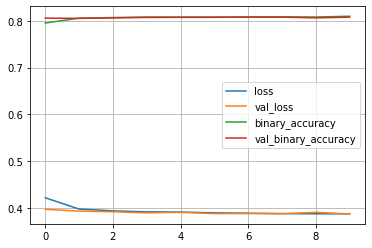

In [23]:
import matplotlib.pyplot as plt

plt.plot(hisotry.history["loss"],label="loss")
plt.plot(hisotry.history["val_loss"],label="val_loss")
plt.plot(hisotry.history["binary_accuracy"],label="binary_accuracy")
plt.plot(hisotry.history["val_binary_accuracy"],label="val_binary_accuracy")
plt.legend()
plt.grid()

# Ligh GBM

In [24]:
clf3=lgb.LGBMClassifier(boosting_type='gbdt',num_leaves=200,learning_rate=0.01,n_estimators=1000,reg_alpha=1.0,reg_lambda=1.0)
clf3.fit(X_train,y_train)

LGBMClassifier(learning_rate=0.01, n_estimators=1000, num_leaves=200,
               reg_alpha=1.0, reg_lambda=1.0)

In [25]:
y_pred=clf3.predict(X_test)
accuracy=accuracy_score(y_pred,y_test)
print(accuracy)

0.8091017687179685


<BarContainer object of 16 artists>

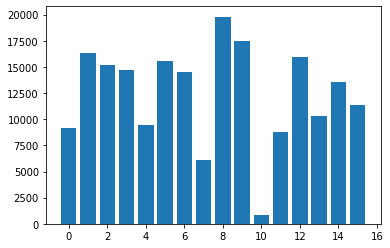

In [26]:
plt.bar(np.arange(len(X.columns)),clf3.feature_importances_)

In [27]:
for i,j in enumerate(X.columns):
    print(i,j)

0 1stIn
1 1stWon
2 2ndWon
3 SvGms
4 ace
5 bpFaced
6 bpSaved
7 df
8 svpt
9 age
10 hand
11 ht
12 id
13 ioc
14 rank
15 rank_points


# Preprocessing

In [28]:
data_filtered = data.drop(columns=["draw_size","loser_name","winner_name","loser_entry","winner_entry","loser_seed","winner_seed","tourney_date","tourney_name"]).dropna()
data_filtered

,best_of,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,l_df,l_svpt,...,w_bpSaved,w_df,w_svpt,winner_age,winner_hand,winner_ht,winner_id,winner_ioc,winner_rank,winner_rank_points
76863,3,30.0,17.0,7.0,8.0,3.0,6.0,2.0,0.0,46.0,...,5.0,0.0,53.0,25.61,R,180.0,101142,ESP,9.0,1487.0
76864,3,30.0,22.0,6.0,8.0,4.0,11.0,7.0,7.0,56.0,...,1.0,1.0,56.0,21.55,R,180.0,101613,USA,94.0,371.0
76865,3,43.0,24.0,14.0,11.0,1.0,8.0,4.0,3.0,68.0,...,2.0,4.0,80.0,25.32,R,185.0,101179,FRA,77.0,468.0
76866,3,61.0,38.0,15.0,13.0,3.0,12.0,8.0,2.0,96.0,...,6.0,1.0,82.0,25.83,R,180.0,101117,GER,65.0,502.0
76867,3,25.0,21.0,12.0,9.0,1.0,6.0,4.0,3.0,49.0,...,2.0,4.0,65.0,19.71,R,185.0,101901,USA,190.0,142.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169648,3,46.0,38.0,11.0,13.0,3.0,4.0,2.0,4.0,70.0,...,2.0,2.0,78.0,37.55,R,185.0,103819,SUI,7.0,4100.0
169650,3,60.0,40.0,23.0,16.0,1.0,9.0,5.0,3.0,100.0,...,4.0,1.0,86.0,27.01,R,185.0,105932,RUS,19.0,1820.0
169652,3,39.0,25.0,5.0,8.0,0.0,9.0,5.0,2.0,61.0,...,0.0,0.0,51.0,28.68,R,175.0,105575,LTU,113.0,516.0
169653,3,22.0,16.0,9.0,8.0,1.0,6.0,2.0,0.0,44.0,...,6.0,2.0,56.0,32.48,R,193.0,104792,FRA,23.0,1560.0


In [29]:
dict_hand = {k:i for i,k in enumerate(np.unique(pd.concat([data_filtered["loser_hand"],data_filtered["winner_hand"]],axis=0)))}
dict_ioc = {k:i for i,k in enumerate(np.unique(pd.concat([data_filtered["loser_ioc"],data_filtered["winner_ioc"]],axis=0)))}
dict_hand

{'L': 0, 'R': 1, 'U': 2}

In [30]:
data_filtered["winner_hand"] = data_filtered["winner_hand"].apply(lambda x: dict_hand[x])
data_filtered["loser_hand"] = data_filtered["loser_hand"].apply(lambda x: dict_hand[x])
data_filtered["winner_ioc"] = data_filtered["winner_ioc"].apply(lambda x: dict_ioc[x])
data_filtered["loser_ioc"] = data_filtered["loser_ioc"].apply(lambda x: dict_ioc[x])
data_filtered["round"] = data_filtered["round"].astype("category")
data_filtered["round"] = data_filtered["round"].cat.codes
data_filtered["score"] = data_filtered["score"].astype("category")
data_filtered["score"] = data_filtered["score"].cat.codes
data_filtered["surface"] = data_filtered["surface"].astype("category")
data_filtered["surface"] = data_filtered["surface"].cat.codes
data_filtered["tourney_id"] = data_filtered["tourney_id"].astype("category")
data_filtered["tourney_id"] = data_filtered["tourney_id"].cat.codes
data_filtered["tourney_level"] = data_filtered["tourney_level"].astype("category")
data_filtered["tourney_level"] = data_filtered["tourney_level"].cat.codes
data_filtered.head(5)

,best_of,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_ace,l_bpFaced,l_bpSaved,l_df,l_svpt,...,w_bpSaved,w_df,w_svpt,winner_age,winner_hand,winner_ht,winner_id,winner_ioc,winner_rank,winner_rank_points
76863,3,30.0,17.0,7.0,8.0,3.0,6.0,2.0,0.0,46.0,...,5.0,0.0,53.0,25.61,1,180.0,101142,24,9.0,1487.0
76864,3,30.0,22.0,6.0,8.0,4.0,11.0,7.0,7.0,56.0,...,1.0,1.0,56.0,21.55,1,180.0,101613,78,94.0,371.0
76865,3,43.0,24.0,14.0,11.0,1.0,8.0,4.0,3.0,68.0,...,2.0,4.0,80.0,25.32,1,185.0,101179,27,77.0,468.0
76866,3,61.0,38.0,15.0,13.0,3.0,12.0,8.0,2.0,96.0,...,6.0,1.0,82.0,25.83,1,180.0,101117,30,65.0,502.0
76867,3,25.0,21.0,12.0,9.0,1.0,6.0,4.0,3.0,49.0,...,2.0,4.0,65.0,19.71,1,185.0,101901,78,190.0,142.0


In [31]:
data_filtered.columns = ['best_of', 'first_1stIn', 'first_1stWon', 'first_2ndWon', 'first_SvGms', 'first_ace',
       'first_bpFaced', 'first_bpSaved', 'first_df', 'first_svpt', 'first_age', 'first_hand',
       'first_ht', 'first_id', 'first_ioc', 'first_rank', 'first_rank_points',
       'match_num', 'minutes', 'round', 'score', 'surface',
       'tourney_id', 'tourney_level', 'second_1stIn', 'second_1stWon',
       'second_2ndWon', 'second_SvGms', 'second_ace', 'second_bpFaced', 'second_bpSaved', 'second_df',
       'second_svpt', 'second_age', 'second_hand', 'second_ht', 'second_id',
       'second_ioc', 'second_rank', 'second_rank_points']
data_filtered["class"]=1
data_filtered.head()

,best_of,first_1stIn,first_1stWon,first_2ndWon,first_SvGms,first_ace,first_bpFaced,first_bpSaved,first_df,first_svpt,...,second_df,second_svpt,second_age,second_hand,second_ht,second_id,second_ioc,second_rank,second_rank_points,class
76863,3,30.0,17.0,7.0,8.0,3.0,6.0,2.0,0.0,46.0,...,0.0,53.0,25.61,1,180.0,101142,24,9.0,1487.0,1
76864,3,30.0,22.0,6.0,8.0,4.0,11.0,7.0,7.0,56.0,...,1.0,56.0,21.55,1,180.0,101613,78,94.0,371.0,1
76865,3,43.0,24.0,14.0,11.0,1.0,8.0,4.0,3.0,68.0,...,4.0,80.0,25.32,1,185.0,101179,27,77.0,468.0,1
76866,3,61.0,38.0,15.0,13.0,3.0,12.0,8.0,2.0,96.0,...,1.0,82.0,25.83,1,180.0,101117,30,65.0,502.0,1
76867,3,25.0,21.0,12.0,9.0,1.0,6.0,4.0,3.0,49.0,...,4.0,65.0,19.71,1,185.0,101901,78,190.0,142.0,1


In [32]:
for i in data_filtered.index:
    columns = ['_1stIn', '_1stWon', '_2ndWon', '_SvGms', '_ace',
       '_bpFaced', '_bpSaved', '_df', '_svpt', '_age', '_hand',
       '_ht', '_id', '_ioc', '_rank', '_rank_points']
    
    print(i)
    if (np.random.rand()<0.5):
        for c in columns:
            aux = data_filtered.loc[i,"second"+c]
            data_filtered.loc[i,"second"+c] = data_filtered.loc[i,"first"+c]
            data_filtered.loc[i,"first"+c] = aux
            data_filtered.loc[i,"class"] = 0
data_filtered

76863
76864
76865
76866
76867
76868
76869
76870
76871
76872
76873
76874
76875
76876
76877
76878
76879
76880
76881
76882
76883
76884
76885
76886
76887
76890
76891
76892
76893
76894
76895
76896
76897
76898
76899
76900
76901
76902
76903
76904
76905
76906
76907
76908
76909
76910
76911
76912
76913
76914
76915
76916
76917
76918
76919
76920
76921
76922
76923
76924
76925
76926
76927
76928
76929
76931
76932
76933
76934
76935
76936
76937
76938
76939
76940
76941
76942
76943
76944
76945
76946
76947
76948
76949
76950
76951
76952
76953
76954
76955
76956
76957
76958
76959
76960
76961
76962
76963
76964
76965
76966
76967
76968
76969
76970
76971
76972
76973
76974
76975
76976
76977
76978
76979
76980
76981
76982
76983
76984
76985
76986
76987
76988
76989
76990
76991
76992
76993
76994
76995
76996
76997
76998
76999
77000
77001
77002
77003
77004
77005
77006
77007
77008
77009
77010
77011
77012
77013
77014
77015
77016
77017
77018
77019
77020
77021
77022
77023
77024
77025
77026
77027
77028
77029
77030
77031
7703

,best_of,first_1stIn,first_1stWon,first_2ndWon,first_SvGms,first_ace,first_bpFaced,first_bpSaved,first_df,first_svpt,...,second_df,second_svpt,second_age,second_hand,second_ht,second_id,second_ioc,second_rank,second_rank_points,class
76863,3,37.0,30.0,7.0,9.0,1.0,6.0,5.0,0.0,53.0,...,0.0,46.0,20.64,1,175.0,101746,39,78.0,459.0,0
76864,3,25.0,17.0,20.0,9.0,5.0,2.0,1.0,1.0,56.0,...,7.0,56.0,31.82,1,188.0,100587,55,220.0,114.0,0
76865,3,55.0,35.0,16.0,12.0,2.0,4.0,2.0,4.0,80.0,...,3.0,68.0,21.70,1,185.0,101601,55,212.0,116.0,0
76866,3,55.0,35.0,14.0,13.0,0.0,10.0,6.0,1.0,82.0,...,2.0,96.0,23.85,0,173.0,101332,38,72.0,483.0,0
76867,3,25.0,21.0,12.0,9.0,1.0,6.0,4.0,3.0,49.0,...,4.0,65.0,19.71,1,185.0,101901,78,190.0,142.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169648,3,46.0,38.0,11.0,13.0,3.0,4.0,2.0,4.0,70.0,...,2.0,78.0,37.55,1,185.0,103819,68,7.0,4100.0,1
169650,3,60.0,40.0,23.0,16.0,1.0,9.0,5.0,3.0,100.0,...,1.0,86.0,27.01,1,185.0,105932,64,19.0,1820.0,1
169652,3,30.0,21.0,14.0,9.0,3.0,1.0,0.0,0.0,51.0,...,2.0,61.0,26.52,1,180.0,106045,78,68.0,770.0,0
169653,3,22.0,16.0,9.0,8.0,1.0,6.0,2.0,0.0,44.0,...,2.0,56.0,32.48,1,193.0,104792,27,23.0,1560.0,1


In [33]:
data_filtered.groupby("class").count()

,best_of,first_1stIn,first_1stWon,first_2ndWon,first_SvGms,first_ace,first_bpFaced,first_bpSaved,first_df,first_svpt,...,second_bpSaved,second_df,second_svpt,second_age,second_hand,second_ht,second_id,second_ioc,second_rank,second_rank_points
class,,,,,,,,,,,,,,,,,,,,,
0,37556,37556,37556,37556,37556,37556,37556,37556,37556,37556,...,37556,37556,37556,37556,37556,37556,37556,37556,37556,37556
1,37273,37273,37273,37273,37273,37273,37273,37273,37273,37273,...,37273,37273,37273,37273,37273,37273,37273,37273,37273,37273


In [34]:
data_filtered = data_filtered.sample(frac=1)
X, y = data_filtered.iloc[:,:-1], data_filtered["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
X_train

,best_of,first_1stIn,first_1stWon,first_2ndWon,first_SvGms,first_ace,first_bpFaced,first_bpSaved,first_df,first_svpt,...,second_bpSaved,second_df,second_svpt,second_age,second_hand,second_ht,second_id,second_ioc,second_rank,second_rank_points
80281,3,55.0,36.0,16.0,14.0,5.0,12.0,6.0,3.0,97.0,...,5.0,16.0,92.0,28.22,1,196.0,100950,6,361.0,54.0
105582,3,50.0,35.0,13.0,14.0,7.0,12.0,7.0,8.0,81.0,...,0.0,3.0,78.0,27.15,1,188.0,101917,63,117.0,422.0
85804,3,58.0,32.0,5.0,10.0,1.0,13.0,8.0,1.0,73.0,...,5.0,4.0,77.0,33.14,1,188.0,100656,78,8.0,2108.0
153765,3,77.0,55.0,28.0,16.0,5.0,19.0,16.0,12.0,142.0,...,7.0,3.0,108.0,31.36,1,175.0,103970,24,4.0,7130.0
104774,3,34.0,23.0,12.0,9.0,1.0,10.0,5.0,1.0,73.0,...,0.0,0.0,48.0,22.86,1,180.0,102610,24,26.0,1308.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104771,3,38.0,23.0,9.0,9.0,3.0,9.0,5.0,3.0,64.0,...,4.0,0.0,54.0,23.61,1,180.0,102456,24,13.0,2074.0
149662,3,20.0,16.0,13.0,8.0,8.0,4.0,2.0,2.0,48.0,...,4.0,3.0,76.0,31.38,1,175.0,103656,24,71.0,690.0
127509,3,40.0,36.0,6.0,10.0,10.0,2.0,2.0,0.0,53.0,...,8.0,2.0,64.0,24.61,1,183.0,103602,12,17.0,1350.0
141035,3,54.0,43.0,13.0,14.0,13.0,3.0,1.0,3.0,79.0,...,7.0,2.0,101.0,21.33,1,185.0,105095,41,101.0,713.0


In [35]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [36]:
clf4=lgb.LGBMClassifier(boosting_type='gbdt',num_leaves=200,learning_rate=0.01,n_estimators=1000,reg_alpha=1.0,reg_lambda=1.0)
clf4.fit(X_train,y_train)

LGBMClassifier(learning_rate=0.01, n_estimators=1000, num_leaves=200,
               reg_alpha=1.0, reg_lambda=1.0)

In [37]:
y_pred=clf4.predict(X_test)
accuracy=accuracy_score(y_pred,y_test)
print(accuracy)

0.9393779865554386


<BarContainer object of 40 artists>

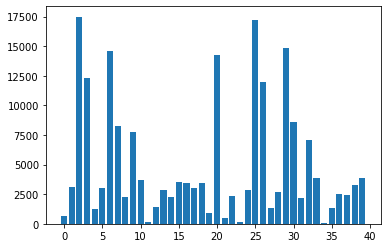

In [38]:
plt.bar(np.arange(len(X.columns)),clf4.feature_importances_)

In [39]:
for i,j in enumerate(X.columns):
    print(i,j)

0 best_of
1 first_1stIn
2 first_1stWon
3 first_2ndWon
4 first_SvGms
5 first_ace
6 first_bpFaced
7 first_bpSaved
8 first_df
9 first_svpt
10 first_age
11 first_hand
12 first_ht
13 first_id
14 first_ioc
15 first_rank
16 first_rank_points
17 match_num
18 minutes
19 round
20 score
21 surface
22 tourney_id
23 tourney_level
24 second_1stIn
25 second_1stWon
26 second_2ndWon
27 second_SvGms
28 second_ace
29 second_bpFaced
30 second_bpSaved
31 second_df
32 second_svpt
33 second_age
34 second_hand
35 second_ht
36 second_id
37 second_ioc
38 second_rank
39 second_rank_points
